In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.integrate import odeint
from scipy.optimize import root
from manim import *
from sympy import *
from sympy.solvers import solve

In [2]:
AXIS_LIMIT = 4
STABILITY_PLOT_STYLE = {"stable spiral": {'marker': 'h', 'fillstyle': 'full', 'color': 'black'}, 
                        "unstable spiral": {'marker': 'h', 'fillstyle': 'none', 'color': 'black'}, 
                        "saddle point (unstable)": {'marker': 'X', 'fillstyle': 'left', 'color': 'red'},
                        "spiral point (mixed stability)": {'marker': 'h', 'fillstyle': 'left', 'color': 'red'},
                        "stable node" : {'marker': 'o', 'fillstyle': 'full', 'color': 'black'},
                        "unstable node" : {'marker': 'o', 'fillstyle': 'none', 'color': 'red'},
                        "node (mixed stability)" : {'marker': '*', 'fillstyle': 'none', 'color': 'red'}}

# Bifurcations

In this notebook, we're going to visualize dynamical systems in two variables. In the process, we will:
* see what their principal behavior is through plotting phase planes
* see where changes don't occur in one variable through plotting nullclines
* see where the system is unchanging through plotting the fixed points
* classify the different fixed points by analyzing the Jacobian matrices of the system
* see how modifying a parameter alters the behavior of the system

## Phase Plane of a Simple Dynamical System

Let's define the simple dynamical system as the following:

$$\frac{dx_0}{dt} = f_0(x_0, x_1)$$

$$\frac{dx_1}{dt} = f_1(x_0, x_1)$$

This is a dynamical system in two variables, $x_0$ and $x_1$. The change in the first variable is described by the function $f_0$ which is dependent on both variables, although this dependence on both variables isn't a necessity. The same is true for the change in the second variable.

Being more concrete, the functions $f_0$ and $f_1$ take the following form:

$$f_0 = -x_0 -2x_1$$

$$f_1 = 4x_0 -x_1$$

This means that $x_0$ changes with an inverse relationship to $x_0$ and $x_0$, and the dependence on $x_1$ is stronger. $x_1$ changes proportionally to $x_0$ and inverse proportionally to $x_1$, and the dependence on $x_0$ is stronger.


Now, we can define a function `evaluate_dynamics` that takes concrete $x$ values and tells us the dynamics at those specific values. In the following function and throughout this notebook, we will be leveraging the `sympy` library which will help us solve equations.

In [3]:
def evaluate_dynamics(x, t, dynamics):
    """
    Evaluate the dynamics of a system at a given state.
    Parameters:
    - x (list): List of state variables.
    - t (float): Time parameter.
    - dynamics (sympy expression): Symbolic expression representing the dynamics of the system.
    Returns:
    - numpy.ndarray: Array of evaluated dynamics.
    """

    # there is a dx/dt for each x
    num_x = len(x)
    assert(num_x == len(dynamics))

    x_symbols = symbols(' '.join([f'x_{i}' for i in range(num_x)]))
    x_symbols_dict = {x_symbols[i]: x[i] for i in range(num_x)}
    dynamics_evaluated = dynamics.subs(x_symbols_dict)
    try:
        return np.array(dynamics_evaluated.tolist()).astype(np.float64).squeeze()
    except:
        return np.array(dynamics_evaluated.tolist()).squeeze()

x_0, x_1 = symbols('x_0 x_1')
f_0 = -x_0 - 2*x_1
f_1 = 4*x_0 - x_1
dynamics = Matrix([f_0, f_1])

In the block of code above, we first defined variables $x_0$ and $x_1$, and then defined our functions $f_0$ and $f_1$ which operate on those variables and represent the derivatives of those variables with respect to time. Then, we neatly packaged them into a single matrix and called it `dynamics`.

In [4]:
dynamics

Matrix([
[-x_0 - 2*x_1],
[ 4*x_0 - x_1]])

### Getting Instantaneous Values
We can try testing this function for different values of $x$, such as $x$ at the origin, $x$ somewhere along one axis, $x$ somewhere along the other axis, and $x$ in a more realistic place.

In [5]:
x = [0, 0]
print(f"x: {x}, dx/dt: {evaluate_dynamics(x, 0, dynamics)}")
x = [2, 0]
print(f"x: {x}, dx/dt: {evaluate_dynamics(x, 0, dynamics)}")
x = [0, 2]
print(f"x: {x}, dx/dt: {evaluate_dynamics(x, 0, dynamics)}")
x = [1, 1]
print(f"x: {x}, dx/dt: {evaluate_dynamics(x, 0, dynamics)}")

x: [0, 0], dx/dt: [0. 0.]
x: [2, 0], dx/dt: [-2.  8.]
x: [0, 2], dx/dt: [-4. -2.]
x: [1, 1], dx/dt: [-3.  3.]


### Plotting the Phase Plane

Now instead of evaluating the dynamics over a few random points, we can define a grid over which to evaluate the dynamics, and then plot the results to get a more comprehensive picture of what the system dynamics look like.

In [6]:
def get_phase_plane(dynamics, x_0_range=(-AXIS_LIMIT, AXIS_LIMIT), x_1_range=(-AXIS_LIMIT, AXIS_LIMIT), num_points=20):
    """
    Generates a phase plane for a given dynamical system.
    Parameters:
    - dynamics (function): The function that defines the dynamics of the system.
    - x_0_range (tuple, optional): The range of values for the x-axis. Defaults to (-AXIS_LIMIT, AXIS_LIMIT).
    - x_1_range (tuple, optional): The range of values for the y-axis. Defaults to (-AXIS_LIMIT, AXIS_LIMIT).
    - num_points (int, optional): The number of points to generate along each axis. Defaults to 20.
    Returns:
    - X0 (ndarray): The x-coordinates of the grid points.
    - X1 (ndarray): The y-coordinates of the grid points.
    - dx_0 (ndarray): The x-components of the trajectory tangent vector.
    - dx_1 (ndarray): The y-components of the trajectory tangent vector.
    """

    x_0 = np.linspace(*x_0_range, num_points)
    x_1 = np.linspace(*x_1_range, num_points)

    X0, X1 = np.meshgrid(x_0, x_1)
    # projections of the trajectory tangent vector 
    dx_0 = np.zeros(X0.shape)
    dx_1 = np.zeros(X1.shape)

    shape1, shape2 = X1.shape

    for index_shape1 in range(shape1):
        for index_shape2 in range(shape2):
            dxdt_at_x = evaluate_dynamics([X0[index_shape1, index_shape2],X1[index_shape1, index_shape2]], 0, dynamics)
            dx_0[index_shape1, index_shape2]=dxdt_at_x[0]
            dx_1[index_shape1, index_shape2]=dxdt_at_x[1]   
    return X0, X1, dx_0, dx_1  

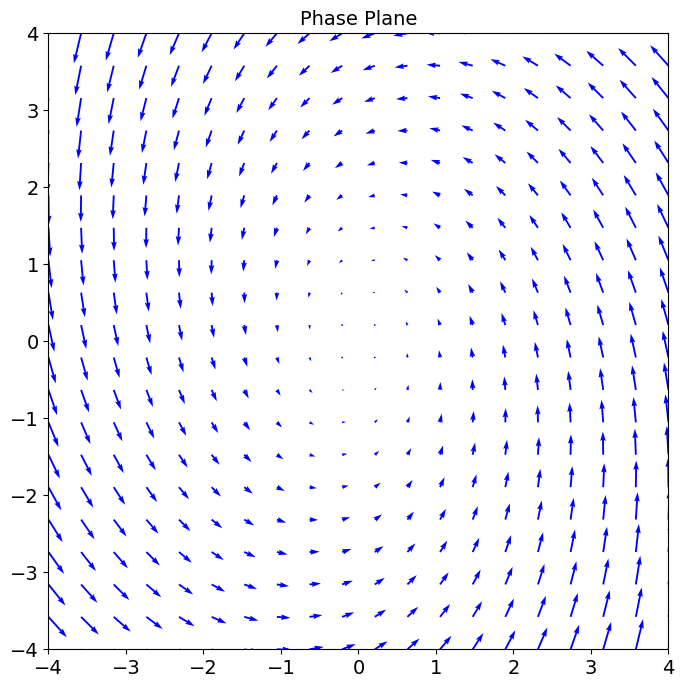

In [7]:
def plot_phase_plane(dynamics):
    """
    Plots the phase plane of a given dynamics system.
    Parameters:
     - dynamics (function): The dynamics function that describes the system.
    """

    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    plt.figure(figsize=(8, 8))
    plt.quiver(X0, X1, dx_0, dx_1, color='b')
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.title('Phase Plane', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

plot_phase_plane(dynamics)

### Plotting the trajectory from an initial state

We can also plot the trajectory that the system takes given an initial state and overlay that on the phase plane. The `scipy` library has a function called `odeint` which takes a set of functions and an initial state and generates its trajectory through integration.

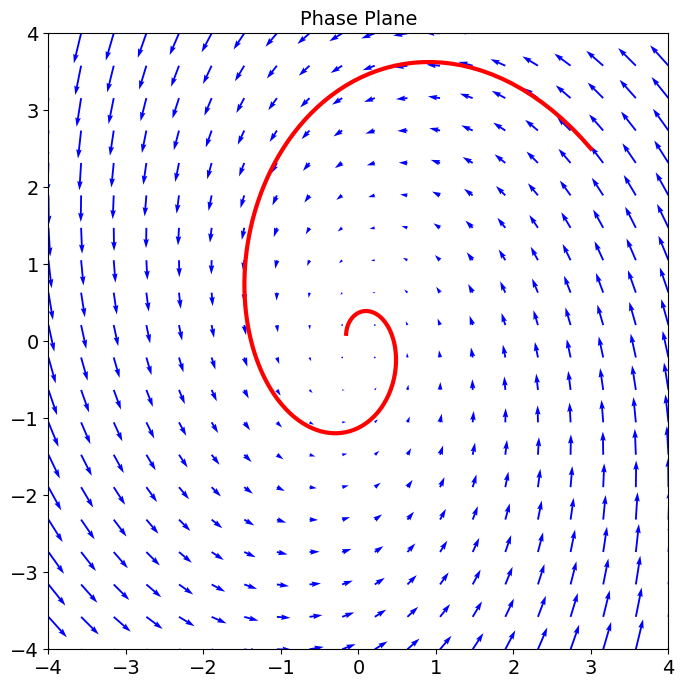

In [8]:
initial_state=np.array([3, 2.5])
simulation_time=np.linspace(0, 3, 200)

def plot_phase_plane_with_state_trajectory(dynamics, initial_state, simulation_time):
    """
    Plots the phase plane with the state trajectory for a given set of dynamics, initial state, and simulation time.
    Parameters:
    - dynamics (function): The function that defines the system dynamics.
    - initial_state (array-like): The initial state of the system.
    - simulation_time (array-like): The time points at which to simulate the system.
    """

    solution_state=odeint(evaluate_dynamics, initial_state, simulation_time, args=(dynamics,))
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    #adjust the figure size
    plt.figure(figsize=(8, 8))
    # plot the phase portrait
    plt.quiver(X0,X1,dx_0,dx_1,color='b')
    # adjust the axis limits
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    # add the state trajectory plot
    plt.plot(solution_state[:, 0], solution_state[:, 1], color='r', linewidth=3)
    # insert the title
    plt.title('Phase Plane', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
plot_phase_plane_with_state_trajectory(dynamics, initial_state, simulation_time)

We can see based on the plot above that a point starting at (3, 2.5) will spiral into the center over time. It is likely that once the system reaches the center state, it would stay there. We can determine if this is the case by taking a closer look at the fixed points and nullclines.

### Adding fixed points and nullclines

We can already see based on the behavior of the system above that there is probably a fixed point in the middle of the diagram. We should plot it as well as the nullclines, which are where the system doesn't change with respect to one variable. The system is simple enough that simply setting the derivatives to 0 and moving one variable to the other side would give us the nullclines:

$$x_0 = -2x_1$$
$$x_1 = 4x_0$$

This rearrangement of the variables shows that $\frac{dx_0}{dt}$ is 0 when $x_0$ is equal to -2 times $x_1$. Likewise, $\frac{dx_1}{dt}$ is 0 when $x_1$ is 4 times $x_0$.

Using `sympy`, we can use the `solve` function to solve a function for a specific variable. We simply index into the matrix to tell it which derivative we want to solve for, and tell it which variable we want the equation for.

In [9]:
solve(dynamics[0], x_0)

[-2*x_1]

In [10]:
solve(dynamics[1], x_1)

[4*x_0]

Similarly, we can give `solve` the entire Matrix of dynamics as well as all the variables in the system, and it can determine where the system will have no rate of change - the fixed point(s).

In [11]:
solve(dynamics, (x_0, x_1))

{x_0: 0, x_1: 0}

In the following cell of functions, we get all of the nullclines and all of the fixed points. There is some additional code to remove points that are imaginary. Furthermore, the stability of the fixed points can be determined by first getting the Jacobian matrix of the dynamics, which represents the partial derivative of the system with respect to each variable, and then evaluating the matrix at the fixed points, and calculating the Eigenvalues of the resulting matrix. Depending on the number of real and imaginary components, the fixed point can be classified as stable, unstable, and further given descriptions about whether they are saddle nodes when unstable, and whether they are spiraling (inward if stable, outward if unstable). 

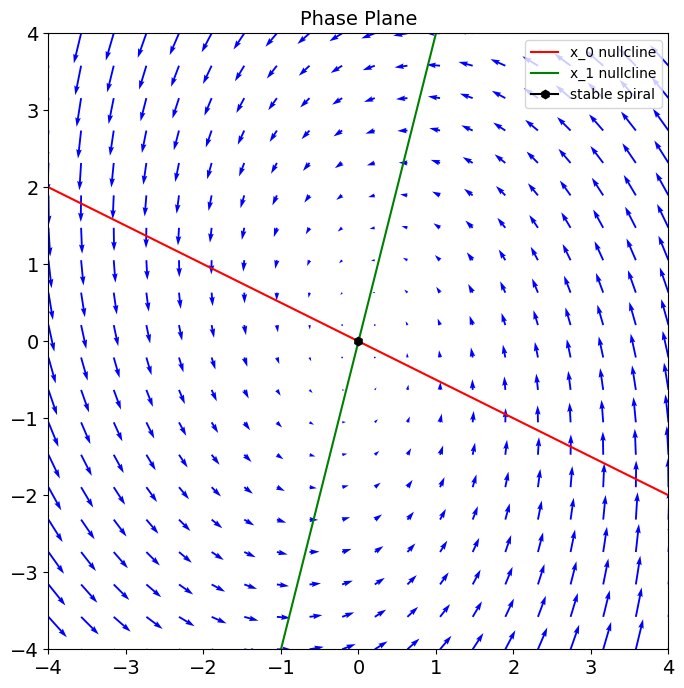

In [12]:
def get_variables(dynamics):
    """
    Returns a list of variables used in the dynamics.
    Parameters:
    - dynamics (sympy.Expr): The dynamics expression.

    Returns:
    - list: A list of variables used in the dynamics.
    """

    symbols = list(dynamics.free_symbols)
    variables = [var for var in symbols if str(var).startswith('x_')]
    return variables

def coordinate_is_real(*points):
    """
    Check if the given coordinates are real numbers.
    Parameters:
    - points: Variable number of points to be checked.
    Returns:
    - bool: True if all coordinates are real numbers, False otherwise.
    """

    for point in points:
        if isinstance(point, evalf.EvalfMixin) and not point.is_real:
            return False
    return True

def find_fixed_points(dynamics, x):
    """
    Finds the fixed points of a given dynamical system.
    Parameters:
    - dynamics (Matrix): Matrix of equations representing the dynamical system.
    - x (list): List of variables representing the sympy symbols in the dynamics.
    Returns:
    - real_fixed_points (list): List of tuples representing the real fixed points of the dynamical system.
    """

    x_sorted = sorted(x, key=lambda x: str(x))
    fixed_points = solve(dynamics, tuple(x_sorted))
    real_fixed_points = []
    if type(fixed_points) == dict:
        fixed_points = list(fixed_points.values())
        if not coordinate_is_real(*fixed_points):
            return real_fixed_points
        real_fixed_points.append(tuple(fixed_points))
    else:
        for fixed_point in fixed_points:
            if not coordinate_is_real(*fixed_point):
                continue
            real_fixed_points.append(fixed_point)
    return real_fixed_points

def find_nullclines(dynamics, x):
    """
    Finds the nullclines of a dynamical system.
    Parameters:
    - dynamics (Matrix): A Matrix of equations representing the dynamical system.
    - x (list): List of variables representing the sympy symbols in the dynamics.
    Returns:
    - nullclines (dict): A dictionary containing the nullclines for each variable.
    """

    nullclines = {}
    for i in range(len(dynamics)):
        nullclines[x[i]] = solve(dynamics[i], x[i])
    return nullclines

def filter_imaginary_coordinates(*coordinates):
    """
    Filters out the imaginary coordinates from the given set of coordinates.
    Parameters:
    - coordinates: Variable number of coordinate arrays.
    Returns:
    - If only one set of coordinates is provided, returns a list of real coordinates.
    - If multiple sets of coordinates are provided, returns a tuple of lists, where each list contains the real coordinates for the corresponding set of coordinates.
    """

    assert(all([len(coordinates[0]) == len(coordinate) for coordinate in coordinates]))
    real_coordinates = [[] for _ in range(len(coordinates))]
    # loop over the individual points
    for i in range(len(coordinates[0])):
        if not coordinate_is_real(*[coordinate[i] for coordinate in coordinates]):
            continue
        for j in range(len(coordinates)):
            real_coordinates[j].append(coordinates[j][i])
    return real_coordinates[0] if len(coordinates) == 1 else tuple(real_coordinates)

def classify_fixed_point(eigenvalues):
    """
    Classifies a fixed point based on its eigenvalues.
    Parameters:
    - eigenvalues (list): A list of eigenvalues of the fixed point.
    Returns:
    - str: The classification of the fixed point.
    """

    real_components = [eigenvalue.as_real_imag()[0] for eigenvalue in eigenvalues]
    imaginary_components = [eigenvalue.as_real_imag()[1] for eigenvalue in eigenvalues]

    has_imaginary = any([imaginary_component != 0 for imaginary_component in imaginary_components])
    has_positive_real = any([real_component > 0 for real_component in real_components])
    has_negative_real = any([real_component < 0 for real_component in real_components])

    if has_imaginary:
        if all(real < 0 for real in real_components):
            return 'stable spiral'
        elif all(real > 0 for real in real_components):
            return 'unstable spiral'
        else:
            return "spiral point (mixed stability)"
    elif has_positive_real and has_negative_real:
        return 'saddle point (unstable)'
    elif all(real < 0 for real in real_components):
        return 'stable node'
    elif all(real > 0 for real in real_components):
        return 'unstable node'
    else:
        return 'node (mixed stability)'

def get_fixed_point_stabilities(fixed_points, dynamics):
    """
    Calculates the stabilities of the given fixed points for a given dynamics system.
    Parameters:
    - fixed_points (list): A list of tuples representing the coordinates of the fixed points.
    - dynamics (object): An object representing the dynamics system.
    Returns:
    - list: A list of stabilities corresponding to each fixed point.
    """

    J = dynamics.jacobian([x_0, x_1])
    stabilities = []
    for fixed_point in fixed_points:
        J_at_fixed_point = J.subs({x_0: fixed_point[0], x_1: fixed_point[1]})
        eigenvalues = J_at_fixed_point.eigenvals()
        stabilities.append(classify_fixed_point(eigenvalues))
    return stabilities

def plot_phase_plane_with_nullclines_and_fixed_points(dynamics, interactive=False):
    """
    Plots the phase plane with nullclines and fixed points for a given set of dynamics.
    Parameters:
    - dynamics (list): List of symbolic expressions representing the dynamics of the system.
    - interactive (bool, optional): Flag indicating whether to clear the current figure before plotting. 
                                      Defaults to False.
    """

    if interactive:
        plt.clf()
    X0, X1, dx_0, dx_1 = get_phase_plane(dynamics)
    x = get_variables(dynamics)
    x = sorted(x, key=lambda x: str(x))
    assert(len(x) == len(dynamics))
    nullclines = find_nullclines(dynamics, x)
    fixed_points = find_fixed_points(dynamics, x)
    stabilities = get_fixed_point_stabilities(fixed_points, dynamics)
    num_vars = len(dynamics)
    x = [Symbol(f'x_{i}') for i in range(num_vars)]
    
    line_values = np.linspace(-AXIS_LIMIT, AXIS_LIMIT, 100)
    nullcline_lines = {}
    for variable in x:
        other_variable = [var for var in x if var != variable][0]
        nullcline_lines[variable] = []
        for nullcline in nullclines[variable]:
            nullcline_line = [nullcline.subs(other_variable, value) for value in line_values]
            if str(other_variable) == 'x_1':
                nullcline_lines[variable].append((nullcline_line, line_values))
            elif str(other_variable) == 'x_0':
                nullcline_lines[variable].append((line_values, nullcline_line))
            else:
                raise ValueError(f"Unknown variable {other_variable}")
    for variable in nullcline_lines:
        for i, line in enumerate(nullcline_lines[variable]):
            nullcline_lines[variable][i] = filter_imaginary_coordinates(*line)

    x_0_nullclines = nullcline_lines[x[0]]
    x_1_nullclines = nullcline_lines[x[1]]
    if not interactive:
        plt.figure(figsize=(8, 8))
    plt.quiver(X0,X1,dx_0,dx_1,color='b')
    plt.xlim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.ylim(-AXIS_LIMIT, AXIS_LIMIT)
    plt.title('Phase Plane', fontsize=14)
    if len(x_0_nullclines) > 0:
        for x_0_nullcline_coordinates in x_0_nullclines:
            plt.plot(*x_0_nullcline_coordinates, 'r', label='x_0 nullcline')
    if len(x_1_nullclines) > 0:
        for x_1_nullcline_coordinates in x_1_nullclines:
            plt.plot(*x_1_nullcline_coordinates, 'g', label='x_1 nullcline')
    for i, fixed_point in enumerate(fixed_points):
        stability_style = STABILITY_PLOT_STYLE[stabilities[i]]
        plt.plot(fixed_point[0], fixed_point[1], 
                 marker=stability_style['marker'], fillstyle=stability_style['fillstyle'], 
                 color=stability_style['color'], label=stabilities[i])
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=14)
    if not interactive:
        plt.show()

plot_phase_plane_with_nullclines_and_fixed_points(dynamics)

So now we have determined that there is indeed a fixed point at (0, 0), and not only is it stable, but it is a spiraling one because one of the Eigenvalues of the Jacobian evaluated on that point has an imaginary component, and all real components of the Eigenvalues are negative.

## Phase Plane of a Nonlinear Dynamical System

Making things slightly more complicated, we can now define the dynamics of the system with a nonlinear component in the change of the second variable:

$$ f_0 = x_0+x_1 $$
$$ f_1 = -x_0^2 -x_0 + x_1 $$

Plotting the phase plane, we see more curvature in the vector field and we also see a non-linear nullcline corresponding to the dynamics of the second variable. Because it intersects at two points with the other nullcline, there are now two fixed points instead of one. We can see that near those fixed points the magnitude of the vectors are very small.

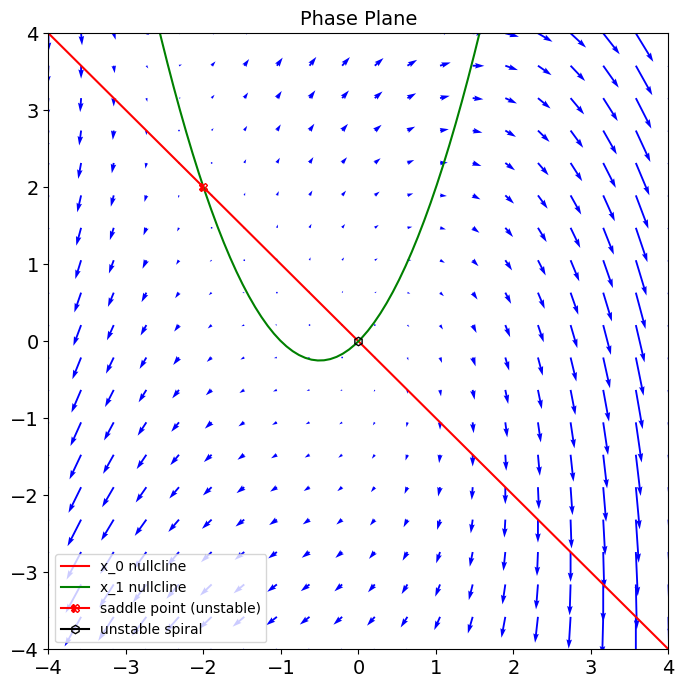

In [13]:
nonlinear_dynamics = [lambda x_0, x_1: x_0 + x_1, lambda x_0, x_1: -x_0**2 - x_0 + x_1]
f_2 = x_0 + x_1
f_3 = -x_0**2 - x_0 + x_1
nonlinear_dynamics = Matrix([f_2, f_3])
plot_phase_plane_with_nullclines_and_fixed_points(nonlinear_dynamics)

### Parameterizing the System and Bifurcating

We can modify the dynamics of the first variable by adding a parameter to it, which would effectively shift its nullcline. Doing so opens up the possibility of the system bifurcating with the adjustment of that parameter. A bifurcation occurs when the number of fixed points in the system changes, and the principal behavior changes qualitatively.

$$ f_0 = x_0+x_1 + c$$
$$ f_1 = -x_0^2 -x_0 + x_1 $$

You can change the parameter $c$ by adjusting the slider and seeing how the phase plane changes. At a certain value for c, the number of fixed points reduces to 1 and then to 0.

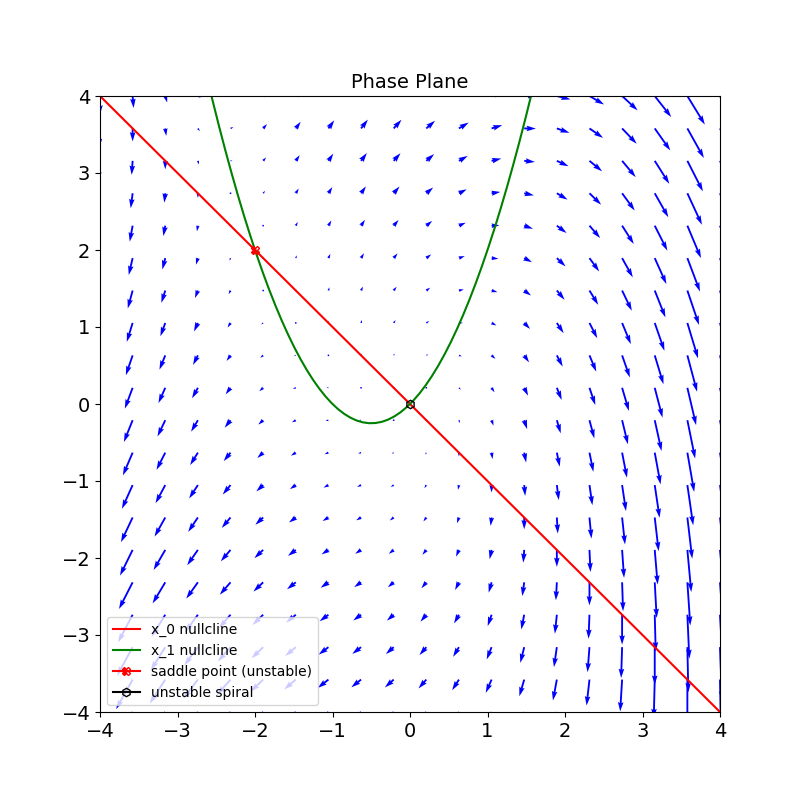

IntSlider(value=0, continuous_update=False, description='parameter c', max=5, min=-5)

In [14]:
%matplotlib ipympl
import ipywidgets as widgets
c = Symbol('c')
linear_dx_0 = x_0 + x_1 + c
nonlinear_dx_1 = -x_0**2 - x_0 + x_1
nonlinear_dynamics = Matrix([linear_dx_0, nonlinear_dx_1])
current_dynamics = nonlinear_dynamics
initial_dynamics = nonlinear_dynamics.subs(c, 0)
plot_phase_plane_with_nullclines_and_fixed_points(initial_dynamics, interactive=False)

def update(change):
    c_value = change.new
    updated_dynamics = current_dynamics.subs(c, c_value)
    plot_phase_plane_with_nullclines_and_fixed_points(updated_dynamics, interactive=True)

int_slider = widgets.IntSlider(
    value=0, 
    min=-5, max=5, step=1,
    description='parameter c',
    continuous_update=False
)
int_slider.observe(update, 'value')
int_slider


### Multiple Nullclines
Let's plot another nonlinear system. This one I took from the Wikipedia page on [saddle-node bifurcations](https://en.wikipedia.org/wiki/Saddle-node_bifurcation). Here is the system:
$$ f_0 = c - x_0^2 $$
$$ f_1 = -x_1 $$

We can see that when $c$ is 0, there are two nullclines which are perpendicular and meet at the origin. Decreasing $c$ eliminates the $x_0$ nullcline and there is no fixed point. Increasing $c$ to above 0 will actually give us two nullclines, one at $\sqrt{c}$ and the other at $-\sqrt{c}$.

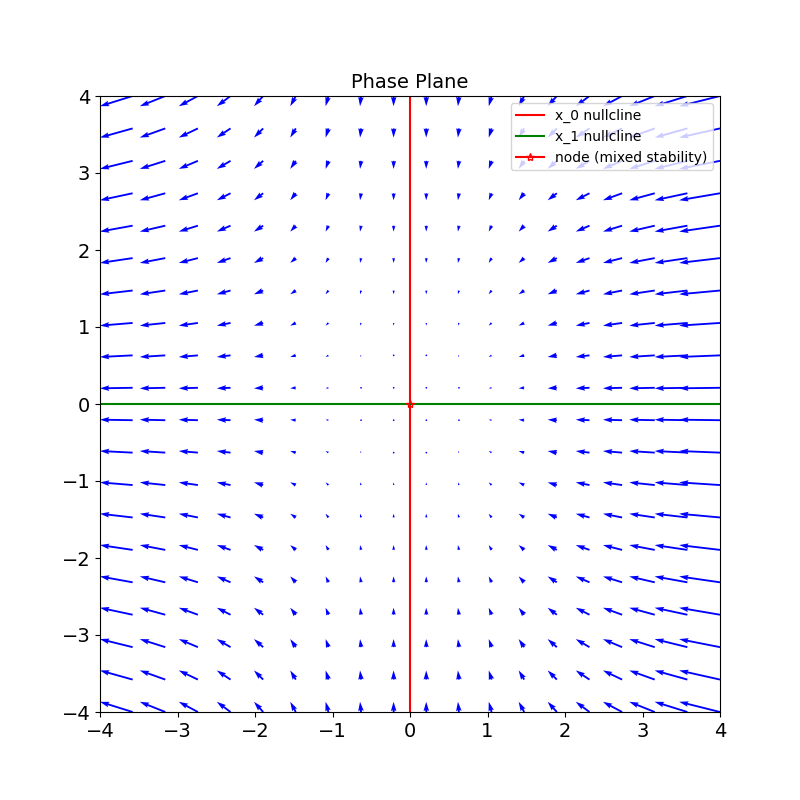

IntSlider(value=0, continuous_update=False, description='parameter c', max=5, min=-5)

In [15]:
nonlinear_dx_0 = c-x_0**2
linear_dx_1 = -x_1
nonlinear_dynamics = Matrix([nonlinear_dx_0, linear_dx_1])
current_dynamics = nonlinear_dynamics
initial_dynamics = nonlinear_dynamics.subs(c, 0)
plot_phase_plane_with_nullclines_and_fixed_points(initial_dynamics, interactive=False)

int_slider = widgets.IntSlider(
    value=0, 
    min=-5, max=5, step=1,
    description='parameter c',
    continuous_update=False
)
int_slider.observe(update, 'value')
int_slider

### Animating the bifurcation

For fun, I'm using the [Manim](https://www.manim.community/) library to generate the phase plane and vector field representing the system. The system has an initial value for the constant $c$ as $-2$, and over time the plot animates to show how the system changes as that constant grows to $5$. Note how at the beginning of the animation, it looks like the system is moving all states towards the left, and as $c$ increases, the nullclines appear and an attractor fixed point also develops on the right side of the plane, and a repelling fixed point develops on the left side.

In [19]:
%%manim -qm -v WARNING PhasePortrait

class PhasePortrait(Scene):
    def construct(self):
        # Create axes
        axes = Axes(
            x_range=[-5, 5, 1],
            y_range=[-5, 5, 1],
            axis_config={"color": BLUE}
        )

        labels = axes.get_axis_labels(x_label="x", y_label="y")
        A = ValueTracker(-2)

        # Define the vector field
        def vector_field_func(pos):
            x, y = pos[:2]
            return np.array([A.get_value()-x**2, -y, 0])

        vector_field = ArrowVectorField(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            colors=[BLUE, GREEN]
        )
        vector_field.add_updater(lambda func : func.become(ArrowVectorField(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            colors=[BLUE, GREEN]
        )))

        # Create stream lines (optional for better visualization)
        stream_lines = StreamLines(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            stroke_width=1,
            max_anchors_per_line=30,
            virtual_time=3,
        )

        stream_lines.add_updater(lambda func : func.become(StreamLines(
            vector_field_func,
            x_range=[-5, 5],
            y_range=[-5, 5],
            stroke_width=1,
            max_anchors_per_line=30,
            virtual_time=3,
        )))

        # Add everything to the scene
        self.add(axes, labels, vector_field, stream_lines)
        self.play(A.animate.set_value(5),run_time=7)
        self.wait(5)

Manim Community v0.18.1